In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import HTML
from scipy.io import loadmat
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors
import seaborn as sn
from mpl_toolkits import mplot3d
from itertools import compress
from mpl_toolkits.mplot3d import Axes3D
import random
import multiprocessing
from joblib import Parallel, delayed
import os
from pathlib import Path
NumThread=(multiprocessing.cpu_count()-1)*2
import pickle
from joblib import Parallel, delayed
from multiprocessing import cpu_count, Pool
import glob
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist

In [2]:
def normalize_length(saccade, length=42):   #but based on the histogram, 42 seems to be more correct, cgeck with Austin
    saccade = np.asarray(saccade) 
    x = np.linspace(0, 1, num=saccade.shape[0])
    x_new = np.linspace(0, 1, num=length)
    f = interp1d(x, saccade)
    return f(x_new)

In [3]:
def load(mat_file = '', channels = [126]):
    mat = loadmat(mat_file)
    #Extract the saccade_data cell array.This will be a structured numpy array.
    saccade_data = mat[list(mat.keys())[-1]][0]
    
    #selectively return the channels of interest ommitting all other
    extracted_saccades=[]
    for saccade in saccade_data:
        channel_sacs = []
        for channel in channels:
            channel_sacs.append( np.ndarray.tolist(saccade[channel]) )
        extracted_saccades.append(np.array(channel_sacs))
    return extracted_saccades

def normalize(saccades):
    for i in range(len(saccades)):
        for j in range(len(saccades[i])):
            saccades[i][j] = (saccades[i][j]-np.mean(saccades[i][j]))/np.std(saccades[i][j])
    return saccades

def car_to_polar(saccades):
    for i in range(len(saccades)):
        x=saccades[i][0]
        y=saccades[i][1]
        rho=np.sqrt(x**2+y**2)
        phi=np.arctan2(y,x)
        saccades[i]=np.array([rho,phi])
    return saccades

In [4]:
sac_pos = load('/mnt/home/mplomecka/saccades/data/postprocessing/data/filteredData_proright_young.mat')
trajectories=[]
for sac in sac_pos[:2000]:
    trajectories.append(sac[0])

In [5]:
martyna_indexes = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/martyna_indexes.npy')
print("Shape of martyna_indexes:", martyna_indexes.shape)
#first few entries 
print("First few entries:", martyna_indexes[:5])

martyna_results = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/martyna_results.npy', allow_pickle=True)
for key, value in martyna_results.item().items():
    print(f"Shape of {key}:", np.shape(value))

Shape of martyna_indexes: (1000,)
First few entries: [4218 1371 2660 2688 1615]
Shape of lyv_vc: (3, 3, 42000)
Shape of les_vc: (42000, 3)
Shape of vc: (3, 42000)
Shape of ly_ids: (42000,)


In [6]:
shapes = [np.shape(sac) for sac in sac_pos]
unique_shapes = set(shapes)
print("Number of saccades:", len(sac_pos))
print("Unique shapes within the loaded saccades data:", unique_shapes)

Number of saccades: 5006
Unique shapes within the loaded saccades data: {(1, 37), (1, 34), (1, 40), (1, 46), (1, 43), (1, 49), (1, 33), (1, 39), (1, 36), (1, 42), (1, 45), (1, 51), (1, 48), (1, 35), (1, 38), (1, 44), (1, 41), (1, 47), (1, 50)}


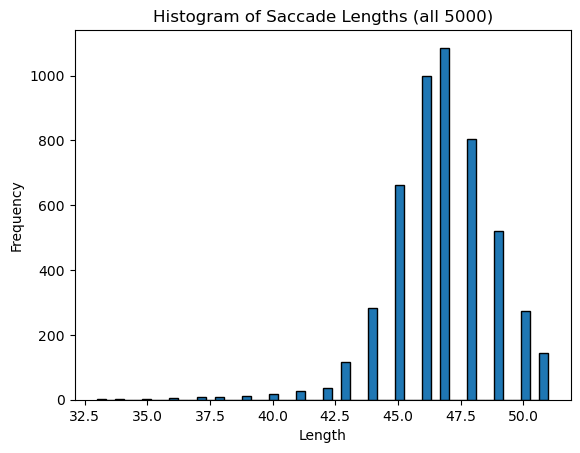

In [7]:
lengths = [sac.shape[1] for sac in sac_pos]
plt.hist(lengths, bins=50, edgecolor='black') 
plt.title('Histogram of Saccade Lengths (all 5000)')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

1000


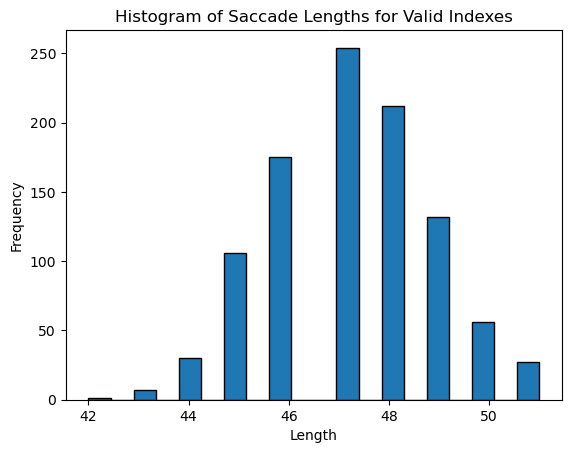

In [8]:
# Extract the lengths of the saccades from the second dimension of each shape for the given indexes
lengths = [sac_pos[idx].shape[1] for idx in martyna_indexes]
print(len(lengths))

plt.hist(lengths, bins=20, edgecolor='black') 
plt.title('Histogram of Saccade Lengths for Valid Indexes')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [9]:
# Extract the saccades based on specific indexes
selected_saccades = [sac_pos[idx][0] for idx in martyna_indexes]
normalized_saccades = [normalize_length(sac) for sac in selected_saccades]

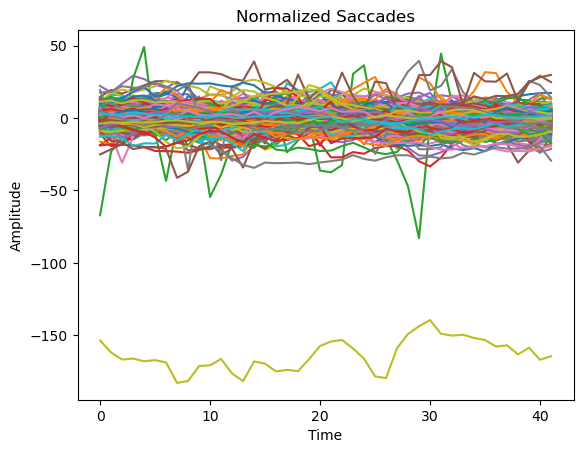

In [10]:
for sac in normalized_saccades:
    plt.plot(sac)

plt.title('Normalized Saccades')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

Number of saccades after filtering: 747
Filtered indexes: [4218, 1371, 2660, 2688, 2973, 3737, 3223, 969, 2166, 865, 4143, 484, 937, 493, 470, 4802, 622, 2657, 2006, 3860, 1854, 4850, 4708, 3930, 905, 1428, 1631, 2656, 2381, 1599, 4044, 1911, 4873, 2809, 4867, 850, 4839, 2659, 294, 3175, 981, 420, 1834, 4001, 2684, 1966, 2356, 3241, 1331, 3383, 1521, 2879, 423, 4238, 3149, 2910, 2467, 2067, 4719, 3129, 2394, 1968, 804, 3497, 3956, 2257, 2526, 3214, 985, 1345, 469, 2388, 4170, 311, 2044, 3634, 3768, 480, 563, 2062, 2124, 3156, 4688, 1654, 42, 147, 2345, 975, 4472, 3616, 1366, 2385, 4757, 2439, 4854, 2058, 4740, 1899, 788, 3407, 2425, 2426, 2405, 461, 674, 1367, 2428, 4842, 2437, 4875, 827, 2431, 3406, 3756, 148, 1901, 3356, 490, 3371, 16, 1885, 3467, 4812, 267, 4735, 1612, 1825, 3625, 3976, 1003, 2925, 2020, 2723, 1389, 3366, 4774, 946, 892, 4020, 446, 1468, 2620, 3385, 790, 2248, 51, 670, 4465, 3757, 3585, 3869, 4874, 1416, 1026, 2247, 2414, 10, 1338, 2402, 3776, 4851, 4574, 528, 4825,

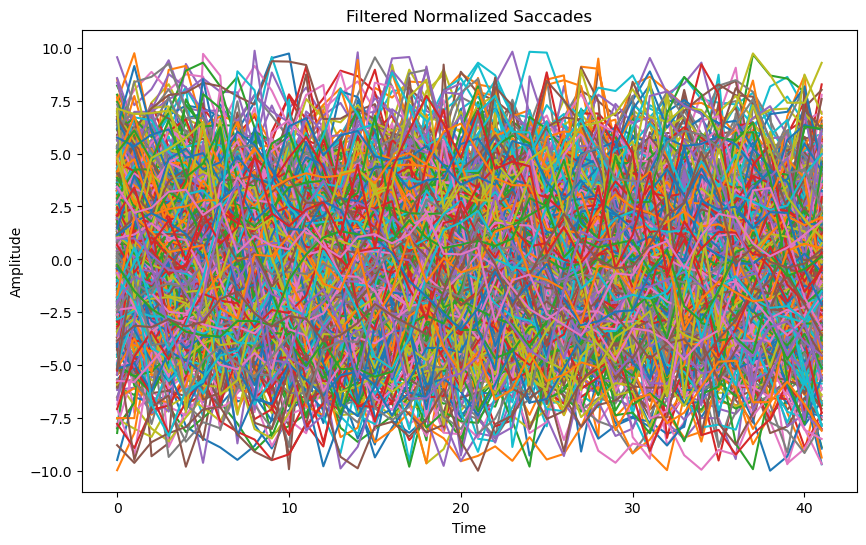

In [11]:
# Filtering the saccades +  keeping the original indexes
filtered_saccades = []
filtered_indexes = []
for sac, idx in zip(normalized_saccades, martyna_indexes):
    if np.all(np.abs(sac) <= 10):
        filtered_saccades.append(sac)
        filtered_indexes.append(idx)

print(f"Number of saccades after filtering: {len(filtered_saccades)}")
print("Filtered indexes:", filtered_indexes)

# only filtered saccades
plt.figure(figsize=(10, 6))
for sac in filtered_saccades:
    plt.plot(sac)

plt.title('Filtered Normalized Saccades')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

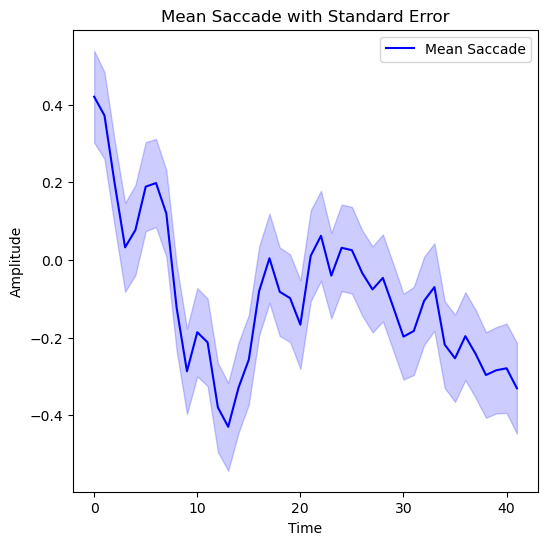

In [12]:
import matplotlib.pyplot as plt
import numpy as np

mean_saccade = np.mean(filtered_saccades, axis=0)
standard_error = np.std(filtered_saccades, axis=0) / np.sqrt(len(filtered_saccades))

plt.figure(figsize=(6, 6))
plt.plot(mean_saccade, label='Mean Saccade', color='blue')

# Adding the "sausage" or shaded region for the standard error
plt.fill_between(range(len(mean_saccade)), mean_saccade - standard_error, mean_saccade + standard_error, color='blue', alpha=0.2)

plt.title('Mean Saccade with Standard Error')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


#### iterate through saccades_lyv_vc and martyna_indexes simultaneously, pairing the corresponding elements together without using the values inside martyna_indexes as indices for saccades_lyv_vc:

In [13]:
martyna_indexes = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/martyna_indexes.npy')
martyna_results = np.load('/mnt/home/mplomecka/saccades/data/postprocessing/data/martyna_results.npy', allow_pickle=True)
lyv_vc = martyna_results.item()['lyv_vc']
saccades_lyv_vc = [lyv_vc[:, :, i*42:(i+1)*42] for i in range(1000)]
selected_lyv_vc = [value for value, idx in zip(saccades_lyv_vc, martyna_indexes)]


In [14]:
selected_lyv_vc_array = np.array(selected_lyv_vc)
print("Dimensions of selected_lyv_vc:", selected_lyv_vc_array.shape)

Dimensions of selected_lyv_vc: (1000, 3, 3, 42)


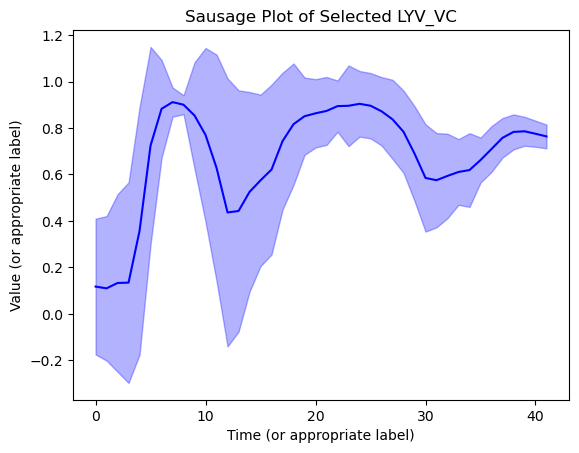

Number of trajectories: 1000


In [15]:
data_slice = selected_lyv_vc_array[:, 1, 1, :]
mean_values = np.mean(data_slice, axis=0)
std_values = np.std(data_slice, axis=0)

# Create time axis if needed
time_axis = np.arange(42)  

# Plot the mean
plt.plot(time_axis, mean_values, color='blue')

# sausage
plt.fill_between(time_axis, mean_values - std_values, mean_values + std_values, color='blue', alpha=0.3)

plt.title('Sausage Plot of Selected LYV_VC')
plt.xlabel('Time (or appropriate label)') 
plt.ylabel('Value (or appropriate label)')
plt.show()
print("Number of trajectories:", data_slice.shape[0])


In [18]:
print("Dimensions of selected_lyv_vc_array:", selected_lyv_vc_array.shape)


Dimensions of selected_lyv_vc_array: (1000, 3, 3, 42)


filter further

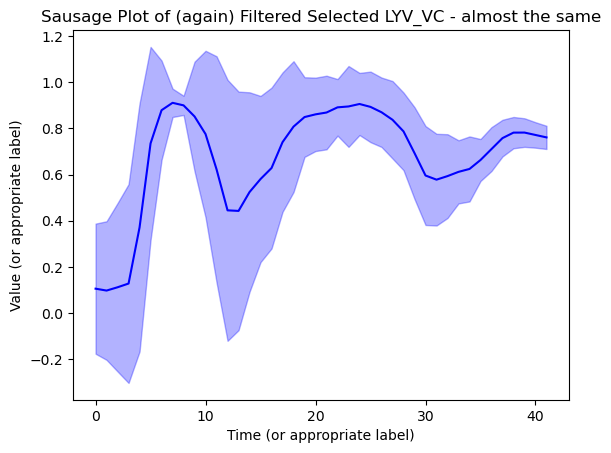

Number of trajectories: 747


In [20]:
filtered_lyv_vc = [selected_lyv_vc[i] for i in range(len(filtered_indexes))]

filtered_lyv_vc_array = np.array(filtered_lyv_vc)
data_slice = filtered_lyv_vc_array[:, 1, 1, :]

# Compute mean and standard deviation
mean_values = np.mean(data_slice, axis=0)
std_values = np.std(data_slice, axis=0)

time_axis = np.arange(42)  

# Plot the mean
plt.plot(time_axis, mean_values, color='blue')

# Fill between for the standard deviation
plt.fill_between(time_axis, mean_values - std_values, mean_values + std_values, color='blue', alpha=0.3)

plt.title('Sausage Plot of (again) Filtered Selected LYV_VC - almost the same')
plt.xlabel('Time (or appropriate label)') 
plt.ylabel('Value (or appropriate label)')
plt.show()

print("Number of trajectories:", data_slice.shape[0])


In [21]:
print("Dimensions of filtered_lyv_vc_array:", filtered_lyv_vc_array.shape)

Dimensions of filtered_lyv_vc_array: (747, 3, 3, 42)


#### Correlation

In [22]:
print("Shape of data_slice:", data_slice.shape)
filtered_saccades_array = np.array(filtered_saccades)
print("Shape of filtered_saccades:", filtered_saccades_array.shape)


Shape of data_slice: (747, 42)
Shape of filtered_saccades: (747, 42)


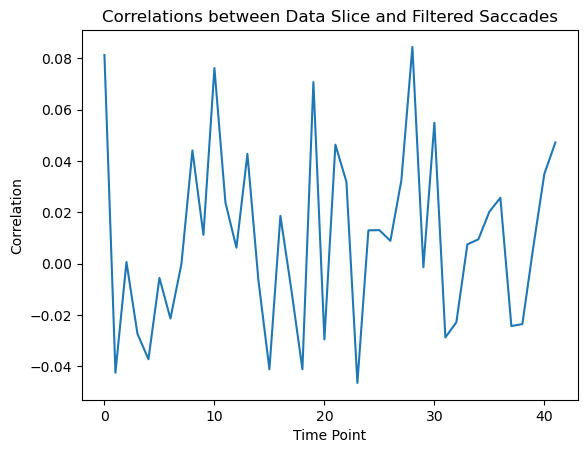

In [23]:
from scipy.stats import pearsonr

filtered_saccades_array = np.array(filtered_saccades)

# List to hold correlations
correlations = []

# Loop over each time point and compute the correlation
for i in range(data_slice.shape[1]):
    corr, _ = pearsonr(data_slice[:, i], filtered_saccades_array[:, i])
    correlations.append(corr)

# Plot the correlations
plt.plot(correlations)
plt.title('Correlations between Data Slice and Filtered Saccades')
plt.xlabel('Time Point')
plt.ylabel('Correlation')
plt.show()
